#pm2.5

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/ikwak2/hj19_timeseries/main/bike_pm2.5/PRSA_data_2010.1.1-2014.12.31.csv?token=ATB7FVYSDM5VD6QOACJUTLDBMQKUE")

In [2]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [3]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill').fillna(method='bfill')

In [4]:

data['cbwd']=data['cbwd'].factorize()[0]

In [5]:
data.columns[5:]

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

In [6]:

from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[5:]].values.reshape(-1,8)
values = values.astype('float32')
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled=scaler.fit_transform(values)
scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))
#scaled = (values - np.mean(values))/np.std(values) 

In [7]:
np.max(values)

1046.0

In [8]:
np.min(values)

-40.0

In [9]:
np.max(values)-np.min(values)

1086.0

In [10]:
'''
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[5:]].values.reshape(-1,8)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit_transform(values)
'''

"\nfrom sklearn.preprocessing import MinMaxScaler\nvalues = data[data.columns[5:]].values.reshape(-1,8)\nvalues = values.astype('float32')\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaled=scaler.fit_transform(values)\n"

In [11]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],scaled[train_size:,]
print(len(train),len(val), len(test),len(test1))

35059 4382 4383 8765


In [12]:

def create_dataset_multistep(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+ look_back: i+ look_back+predict, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [13]:
look_back = 168
predict=24

trainX, trainY = create_dataset_multistep(train, look_back,predict)
valX, valY = create_dataset_multistep(val, look_back,predict)
testX, testY = create_dataset_multistep(test, look_back,predict)

34867
4190
4191


In [14]:
print(trainX.shape)
print(trainY.shape)

(34867, 168, 8)
(34867, 24)


cnn-lstm

In [19]:
first_input = Input(shape=(168,8))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)

#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer25 = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Dropout(0.5)(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(100)(in1)
in1=Dense(100)(in1)
in1=Dropout(0.5)(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/pm2.5_1dcnn-lstm_multi3.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history=model.fit(trainX, trainY, epochs=20, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

In [20]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/fff/saved_weights/pm2.5_1dcnn-lstm_multi3.hdf5")

In [21]:
id_=24*117

X_test=testX.copy()
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

#X_test[id_][:,0].shape

array([ 31.      ,  57.      ,  43.      ,  35.      ,  31.      ,
        30.      ,  25.      ,  33.      ,  39.      ,  40.      ,
        60.      ,  68.      ,  57.      ,  51.      ,  26.      ,
        50.      ,  42.      ,  43.      ,  74.      ,  87.      ,
        78.      ,  77.      ,  91.      ,  99.      ,  92.      ,
        83.      ,  94.      ,  90.      ,  68.      ,  60.      ,
        53.      ,  51.      ,  52.      ,  51.      ,  47.      ,
        47.      ,  59.      ,  59.      ,  74.      ,  93.      ,
       101.      , 111.      , 139.      , 129.      , 127.      ,
       114.      ,  98.      , 102.      , 106.      , 111.      ,
       106.      , 105.      , 108.      , 107.000015, 113.      ,
       126.      , 141.      , 158.      , 170.      , 176.      ,
       183.      , 193.      , 215.      , 215.      , 210.00002 ,
       214.      , 214.      , 272.      , 198.      , 176.      ,
       159.      , 158.      , 137.      , 156.      , 161.   

[0.08985545 0.06971435 0.04957324 0.04650261 0.04363775 0.04125563
 0.03888539 0.06288853 0.08788487 0.14491308 0.20356762 0.2273373
 0.24887523 0.25705037 0.2641888  0.30692434 0.3529363  0.38584265
 0.41735223 0.41990843 0.41894293 0.40296063 0.3849207  0.36698362
 0.34906635 0.31001872 0.26740187 0.22084783 0.17356174 0.16102992
 0.15554948 0.18978937 0.23279004 0.23942196 0.23736829 0.23076801
 0.22299647 0.25866482 0.30636245 0.34426254 0.37925822 0.3913389
 0.39614668 0.39689058 0.39625746 0.40115625 0.40804535 0.41160667
 0.4138938  0.4164421  0.41909724 0.42522663 0.43285176 0.4337777
 0.43164885 0.43217906 0.43398744 0.44541126 0.46172595 0.4740362
 0.48418984 0.49754864 0.51271975 0.52543753 0.5366992  0.5132975
 0.46813628 0.4061737  0.33311966 0.2677422  0.20769082 0.17831409
 0.17130229 0.1707681  0.17519201 0.18864976 0.20936859 0.22332886
 0.23158711 0.2526146  0.284963   0.3330049  0.3956481  0.44400653
 0.47841656 0.5043151  0.5214885  0.519692   0.49750513 0.451509
 0

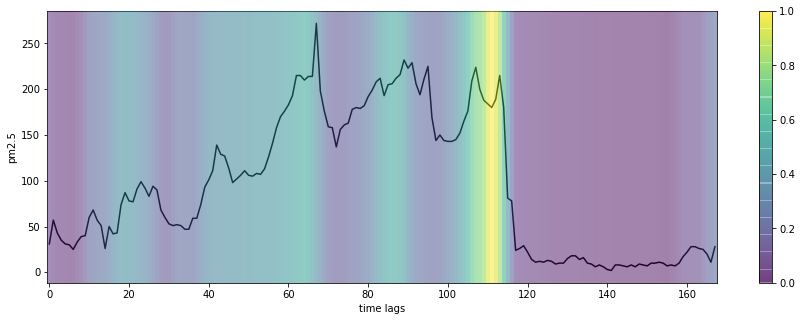

In [22]:
from scipy.ndimage import zoom
import random
import pylab
from tensorflow.keras.models import Model

#id_=24*20

id_=24*127
X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/fff/png/pm2.5_grad cam_cnn-lstm(1).png', dpi=300)

1.0
0.0
1.0
(1, 168, 8)


<Figure size 432x1440 with 0 Axes>

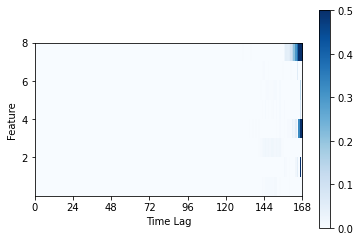

In [23]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(168,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 168, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([24,48,72,96])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time Lag')

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/fff/png/pm2.5_feature importance_cnn-lstm(1).png', dpi=300)

lstm-cnn

In [24]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

#ad1=add([in0,in1])


#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1]

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)

in1=Dense(100, activation='relu')(in1)
in1=Dropout(0.5)(in1)

out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/pm2.5_lstmcnn_multi.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=False,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


#history=model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

In [25]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/fff/saved_weights/pm2.5_lstmcnn_multi.hdf5")

In [26]:
id_=24*127

testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

#X_test[id_][:,0].shape

array([ 11.,  11.,   9.,   7.,   4.,   3.,   4.,   7.,   6.,   6.,  33.,
        40.,  40.,  48.,  44.,  41.,  44.,  45.,  79.,  76.,  79.,  90.,
        73.,  70.,  66.,  59.,  62.,  60.,  41.,  38.,  33.,  18.,  28.,
        46.,  51.,  57.,  37.,  35.,  41.,  46.,  56.,  69.,  79.,  76.,
        65.,  69.,  74.,  79.,  78.,  87.,  82.,  74.,  77.,  84.,  87.,
        91.,  77.,  74.,  84.,  89.,  94.,  92.,  97.,  92.,  98., 116.,
       113., 101.,  87.,  54.,  50.,  42.,  38.,  38.,  39.,  33.,  34.,
        40.,  48.,  45.,  39.,  44.,  57.,  77.,  76.,  98., 101., 104.,
       106., 108.,  98.,  79.,  44.,  33.,  45.,  53.,  47.,  42.,  34.,
        38.,  41.,  56.,  59.,  68.,  79.,  79., 111., 147., 153., 145.,
       143., 144., 200., 239., 185., 163.,  28.,  12.,   9.,   9.,  11.,
        15.,  13.,  14.,  17.,  18.,  16.,  11.,   7.,   9.,  13.,  16.,
         8.,  19.,   8.,   9.,   5.,   2.,   2.,   3.,   3.,   6.,   4.,
         4.,   5.,   6.,   6.,   5.,   4.,   6.,   

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


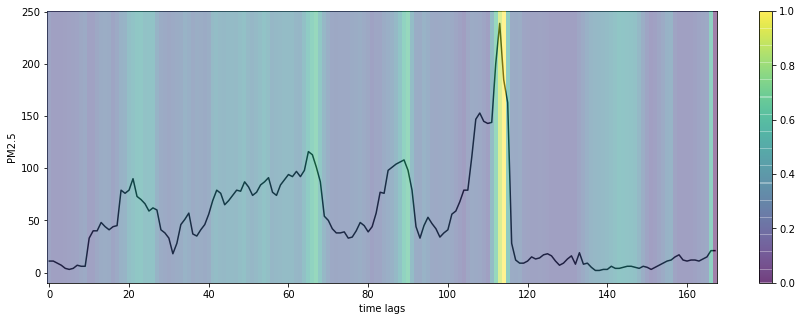

In [27]:
import random
import pylab

#id_=24*20


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('PM2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)
plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png/pm2.5_grad cam_lstm-cnn(1).png', dpi=300)

1.0
0.0
1.0
(1, 168, 8)


<Figure size 432x1440 with 0 Axes>

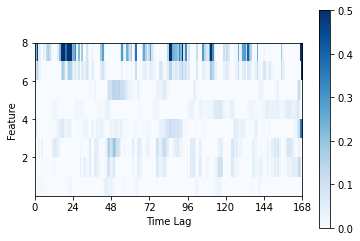

In [28]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(168,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 168, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([24,48,72,96])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time Lag')

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png/pm2.5_feature importance_lstm-cnn(1).png', dpi=300)

lstm-rescnn

In [29]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

#ad1=add([in0,in1])


#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1]

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)

in1=Dense(100, activation='relu')(in1)
in1=Dropout(0.5)(in1)

out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/pm2.5_lstmrescnn_multi.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=False,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history=model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

In [30]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/fff/saved_weights/pm2.5_lstmrescnn_multi.hdf5")

In [31]:
id_=24*127

testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

#X_test[id_][:,0].shape

array([ 11.,  11.,   9.,   7.,   4.,   3.,   4.,   7.,   6.,   6.,  33.,
        40.,  40.,  48.,  44.,  41.,  44.,  45.,  79.,  76.,  79.,  90.,
        73.,  70.,  66.,  59.,  62.,  60.,  41.,  38.,  33.,  18.,  28.,
        46.,  51.,  57.,  37.,  35.,  41.,  46.,  56.,  69.,  79.,  76.,
        65.,  69.,  74.,  79.,  78.,  87.,  82.,  74.,  77.,  84.,  87.,
        91.,  77.,  74.,  84.,  89.,  94.,  92.,  97.,  92.,  98., 116.,
       113., 101.,  87.,  54.,  50.,  42.,  38.,  38.,  39.,  33.,  34.,
        40.,  48.,  45.,  39.,  44.,  57.,  77.,  76.,  98., 101., 104.,
       106., 108.,  98.,  79.,  44.,  33.,  45.,  53.,  47.,  42.,  34.,
        38.,  41.,  56.,  59.,  68.,  79.,  79., 111., 147., 153., 145.,
       143., 144., 200., 239., 185., 163.,  28.,  12.,   9.,   9.,  11.,
        15.,  13.,  14.,  17.,  18.,  16.,  11.,   7.,   9.,  13.,  16.,
         8.,  19.,   8.,   9.,   5.,   2.,   2.,   3.,   3.,   6.,   4.,
         4.,   5.,   6.,   6.,   5.,   4.,   6.,   

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


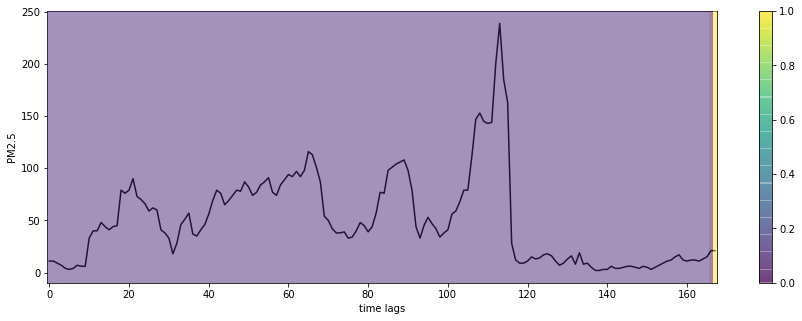

In [32]:
from scipy.ndimage import zoom
import random
import pylab

#id_=24*20


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('PM2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/fff/png/pm2.5_grad cam_lstm-rescnn(1).png', dpi=300)

1.0
0.0
1.0
(1, 168, 8)


<Figure size 432x1440 with 0 Axes>

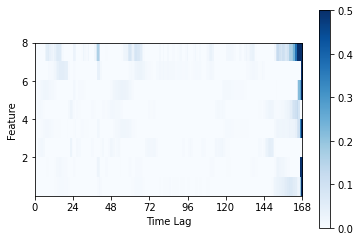

In [33]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(168,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 168, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([24,48,72,96])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time Lag')

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/fff/png/pm2.5_feature importance_lstm-rescnn(1).png', dpi=300)